In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image
import seaborn as sns
import tensorflow as tf

In [2]:
data_dir = '/kaggle/input/v2-plant-seedlings-dataset'

In [3]:
class_names = sorted(os.listdir(data_dir))
print("Classes:", class_names)

image_counts = {cls: len(os.listdir(os.path.join(data_dir, cls))) for cls in class_names}
print("Number of images per class:", image_counts)

Classes: ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherd’s Purse', 'Small-flowered Cranesbill', 'Sugar beet', 'nonsegmentedv2']
Number of images per class: {'Black-grass': 309, 'Charlock': 452, 'Cleavers': 335, 'Common Chickweed': 713, 'Common wheat': 253, 'Fat Hen': 538, 'Loose Silky-bent': 762, 'Maize': 257, 'Scentless Mayweed': 607, 'Shepherd’s Purse': 274, 'Small-flowered Cranesbill': 576, 'Sugar beet': 463, 'nonsegmentedv2': 12}


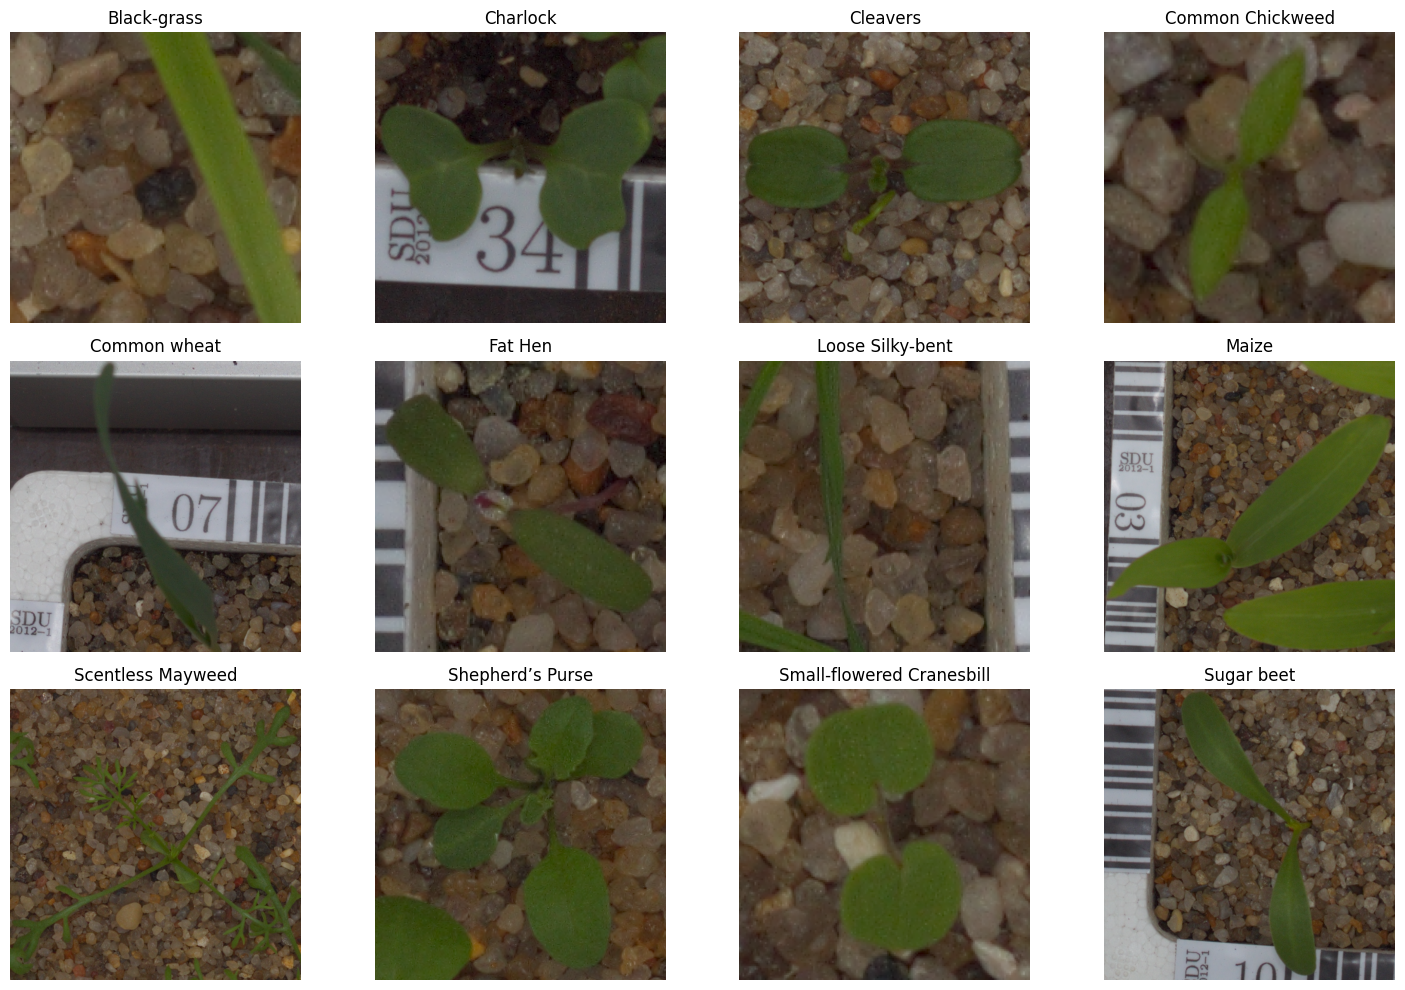

In [4]:
def plot_sample_images(data_dir, class_names, num_samples=1):
    fig, axes = plt.subplots(3, 4, figsize=(15, 10))  # 3 rows, 4 columns
    axes = axes.ravel()
    
    for i, class_name in enumerate(class_names[:12]):  # Ignore 'nonsegmentedv2'
        class_path = os.path.join(data_dir, class_name)
        image_path = glob(os.path.join(class_path, "*.png"))[0]  # Take first image
        img = Image.open(image_path)
        
        axes[i].imshow(img)
        axes[i].set_title(class_name)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

plot_sample_images(data_dir, class_names)

In [5]:
IMG_SIZE = (128, 128)

def load_images(data_dir, class_names, img_size=IMG_SIZE):
    images = []
    labels = []
    
    for label, class_name in enumerate(class_names[:12]):  # Ignore 'nonsegmentedv2'
        class_path = os.path.join(data_dir, class_name)
        image_paths = glob(os.path.join(class_path, "*.png"))
        
        for img_path in image_paths:
            img = cv2.imread(img_path)  # Read image
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            img = cv2.resize(img, img_size)  # Resize to target size
            img = img / 255.0  # Normalize pixel values (0-1)
            
            images.append(img)
            labels.append(label)
    
    return np.array(images), np.array(labels)

images, labels = load_images(data_dir, class_names)

print("Image dataset shape:", images.shape)
print("Labels shape:", labels.shape)

Image dataset shape: (5539, 128, 128, 3)
Labels shape: (5539,)


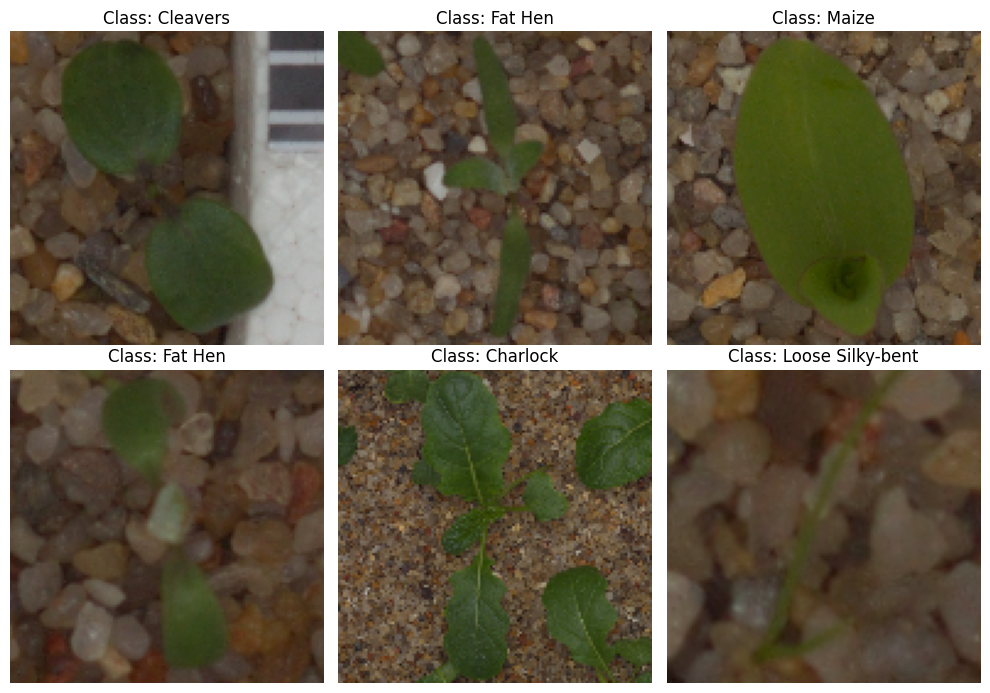

In [6]:
def plot_preprocessed_images(images, labels, class_names, num_samples=6):
    fig, axes = plt.subplots(2, 3, figsize=(10, 7))
    axes = axes.ravel()
    
    indices = np.random.choice(len(images), num_samples, replace=False)
    
    for i, idx in enumerate(indices):
        axes[i].imshow(images[idx])
        axes[i].set_title(f"Class: {class_names[labels[idx]]}")
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

plot_preprocessed_images(images, labels, class_names)

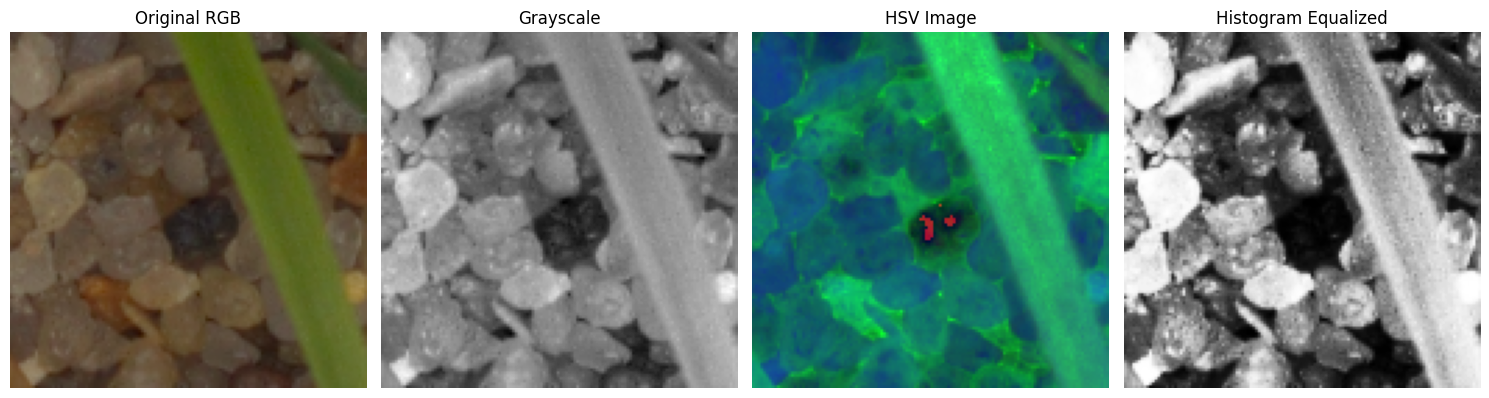

In [7]:
sample_img = images[0]

gray_img = cv2.cvtColor((sample_img * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
hsv_img = cv2.cvtColor((sample_img * 255).astype(np.uint8), cv2.COLOR_RGB2HSV)
equalized_img = cv2.equalizeHist(gray_img)

# Display images
fig, axes = plt.subplots(1, 4, figsize=(15, 5))
axes[0].imshow(sample_img)
axes[0].set_title("Original RGB")
axes[0].axis('off')

axes[1].imshow(gray_img, cmap='gray')
axes[1].set_title("Grayscale")
axes[1].axis('off')

axes[2].imshow(hsv_img)
axes[2].set_title("HSV Image")
axes[2].axis('off')

axes[3].imshow(equalized_img, cmap='gray')
axes[3].set_title("Histogram Equalized")
axes[3].axis('off')

plt.tight_layout()
plt.show()


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


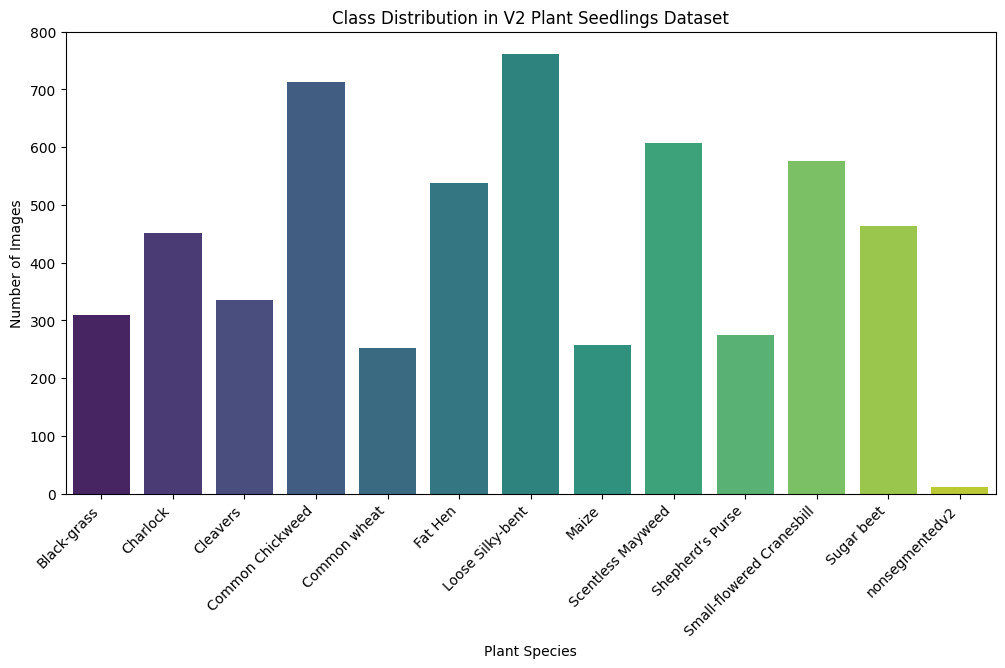

In [8]:
plt.figure(figsize=(12, 6))
sns.barplot(x=list(image_counts.keys()), y=list(image_counts.values()), palette="viridis")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Plant Species")
plt.ylabel("Number of Images")
plt.title("Class Distribution in V2 Plant Seedlings Dataset")
plt.show()

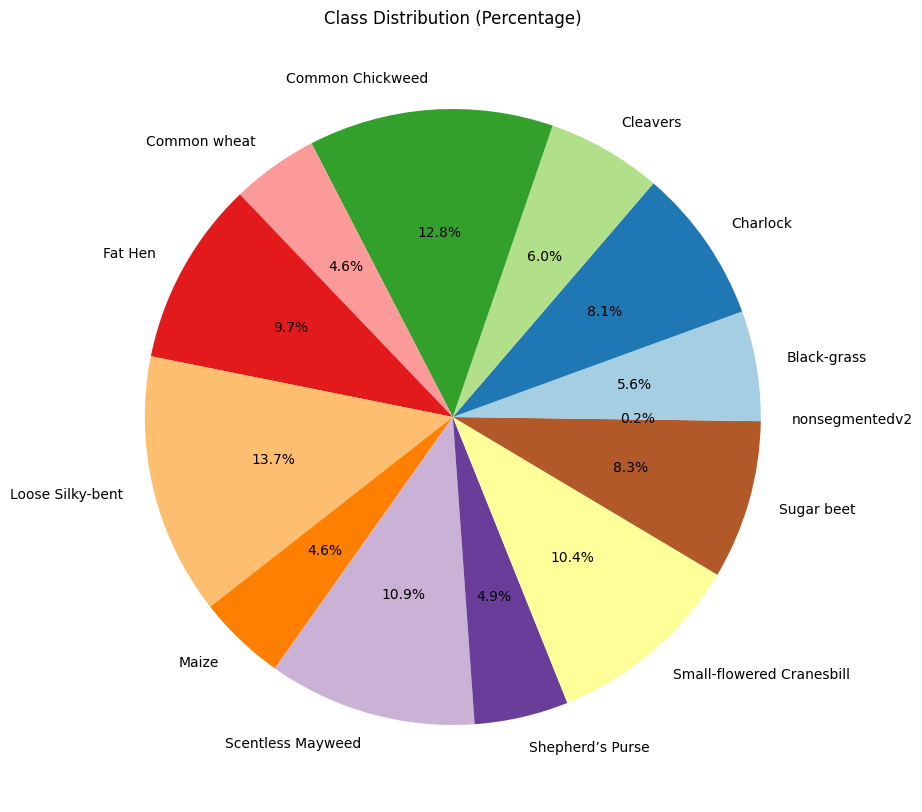

In [9]:
plt.figure(figsize=(10, 10))
plt.pie(image_counts.values(), labels=image_counts.keys(), autopct='%1.1f%%', colors=plt.cm.Paired.colors)
plt.title("Class Distribution (Percentage)")
plt.show()

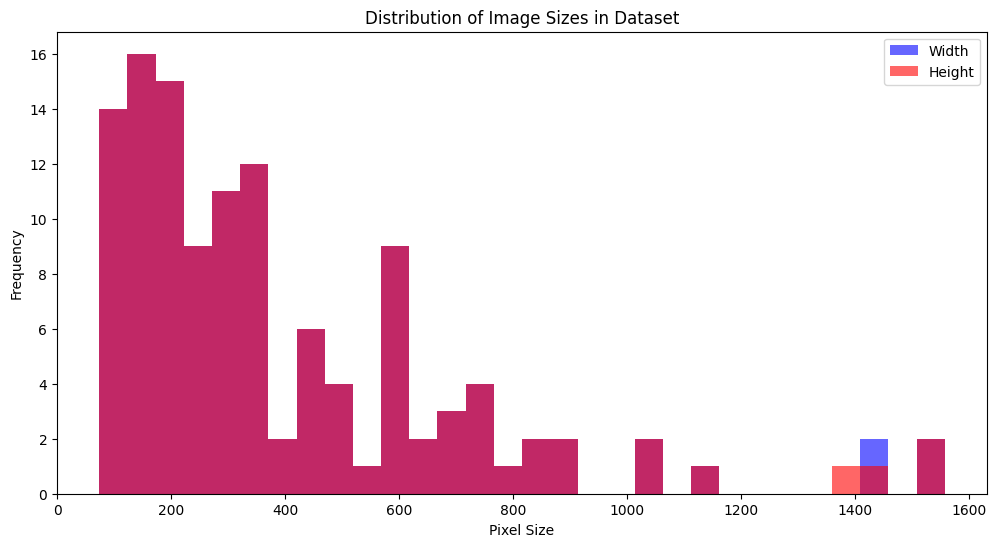

In [10]:
image_shapes = []

for class_name in class_names[:12]:  # Ignore 'nonsegmentedv2'
    class_path = os.path.join(data_dir, class_name)
    image_paths = glob(os.path.join(class_path, "*.png"))

    for img_path in image_paths[:10]:  # Sample 10 images per class for speed
        img = Image.open(img_path)
        image_shapes.append(img.size)  # (width, height)

image_shapes = np.array(image_shapes)

plt.figure(figsize=(12, 6))
plt.hist(image_shapes[:, 0], bins=30, alpha=0.6, label="Width", color='blue')
plt.hist(image_shapes[:, 1], bins=30, alpha=0.6, label="Height", color='red')
plt.xlabel("Pixel Size")
plt.ylabel("Frequency")
plt.title("Distribution of Image Sizes in Dataset")
plt.legend()
plt.show()

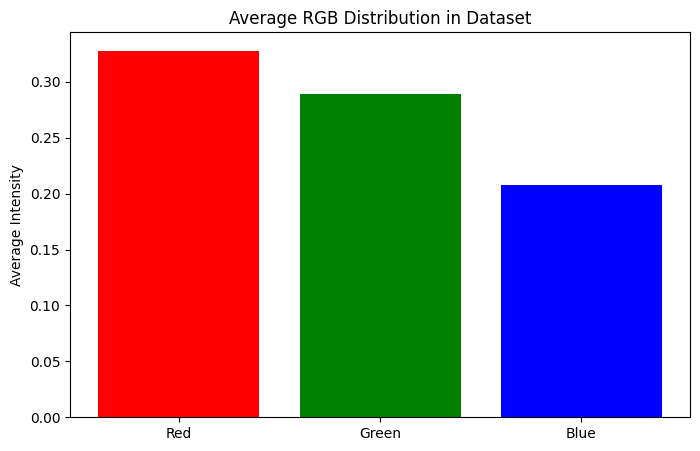

In [11]:
def compute_avg_rgb(images, num_samples=500):
    sampled_images = images[np.random.choice(len(images), num_samples, replace=False)]
    avg_r = np.mean(sampled_images[:, :, :, 0])  # Red channel
    avg_g = np.mean(sampled_images[:, :, :, 1])  # Green channel
    avg_b = np.mean(sampled_images[:, :, :, 2])  # Blue channel
    return [avg_r, avg_g, avg_b]

avg_rgb = compute_avg_rgb(images)

plt.figure(figsize=(8, 5))
plt.bar(["Red", "Green", "Blue"], avg_rgb, color=["red", "green", "blue"])
plt.ylabel("Average Intensity")
plt.title("Average RGB Distribution in Dataset")
plt.show()

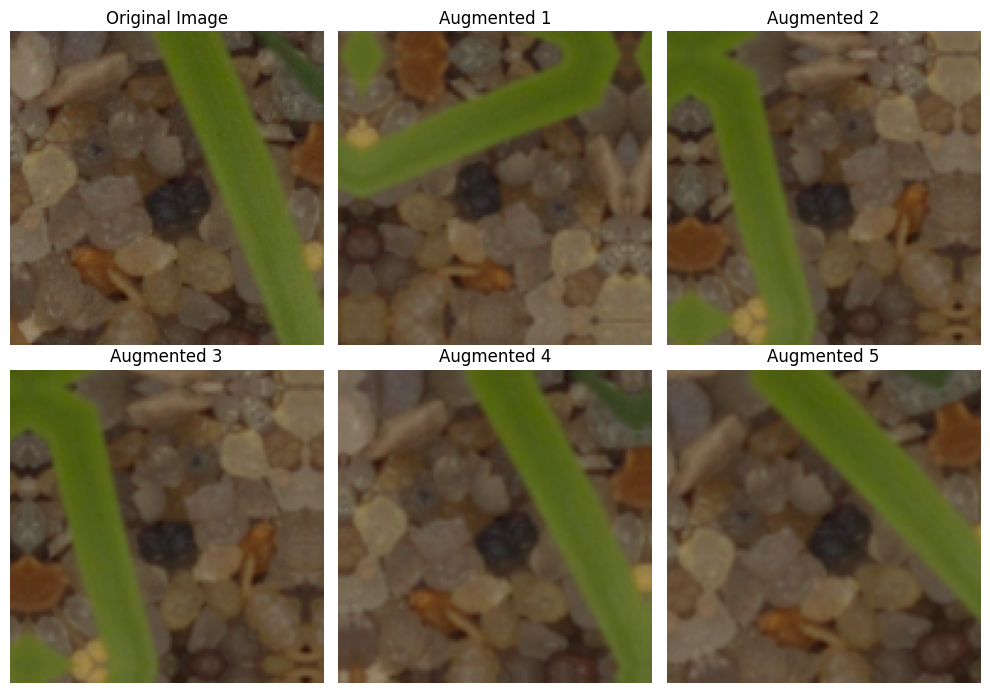

In [12]:
sample_image = (images[0] * 255).astype(np.uint8)

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
])

augmented_images = [data_augmentation(tf.expand_dims(sample_image, 0)) for _ in range(6)]

fig, axes = plt.subplots(2, 3, figsize=(10, 7))
axes = axes.ravel()

axes[0].imshow(sample_image)
axes[0].set_title("Original Image")
axes[0].axis('off')

for i in range(1, 6):
    axes[i].imshow(tf.cast(augmented_images[i-1][0], tf.uint8))
    axes[i].set_title(f"Augmented {i}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [13]:
from sklearn.preprocessing import MultiLabelBinarizer
image_labels = [[class_names[label]] for label in labels]

mlb = MultiLabelBinarizer()
encoded_labels = mlb.fit_transform(image_labels)

print("Classes:", mlb.classes_)
print("Sample label encoding:", encoded_labels[:5])

Classes: ['Black-grass' 'Charlock' 'Cleavers' 'Common Chickweed' 'Common wheat'
 'Fat Hen' 'Loose Silky-bent' 'Maize' 'Scentless Mayweed'
 'Shepherd’s Purse' 'Small-flowered Cranesbill' 'Sugar beet']
Sample label encoding: [[1 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0]]


In [14]:
from sklearn.model_selection import train_test_split

# Split dataset (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(images, encoded_labels, test_size=0.2, random_state=42)

# Print dataset sizes
print("Training set size:", X_train.shape)
print("Validation set size:", X_val.shape)

Training set size: (4431, 128, 128, 3)
Validation set size: (1108, 128, 128, 3)


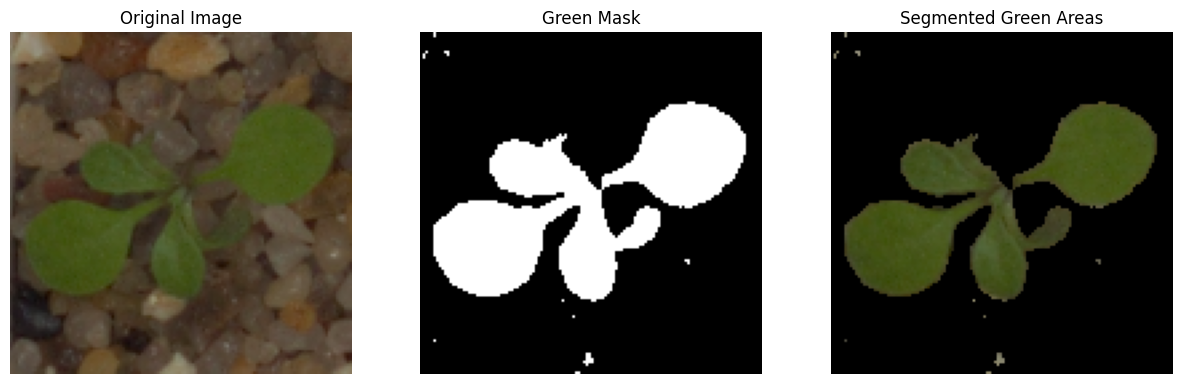

In [15]:
import cv2

# Select a sample image (first image from dataset)
sample_img = (X_train[0] * 255).astype(np.uint8)  # Convert back to 8-bit

# Convert to HSV color space
hsv_img = cv2.cvtColor(sample_img, cv2.COLOR_RGB2HSV)

# Define green color range in HSV
lower_green = np.array([25, 40, 40])   # Lower bound for green
upper_green = np.array([90, 255, 255]) # Upper bound for green

# Create a mask to detect green areas
green_mask = cv2.inRange(hsv_img, lower_green, upper_green)

# Apply mask on the image
segmented_img = cv2.bitwise_and(sample_img, sample_img, mask=green_mask)

# Plot original & segmented images
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(sample_img)
axes[0].set_title("Original Image")
axes[0].axis('off')

axes[1].imshow(green_mask, cmap="gray")
axes[1].set_title("Green Mask")
axes[1].axis('off')

axes[2].imshow(segmented_img)
axes[2].set_title("Segmented Green Areas")
axes[2].axis('off')

plt.show()

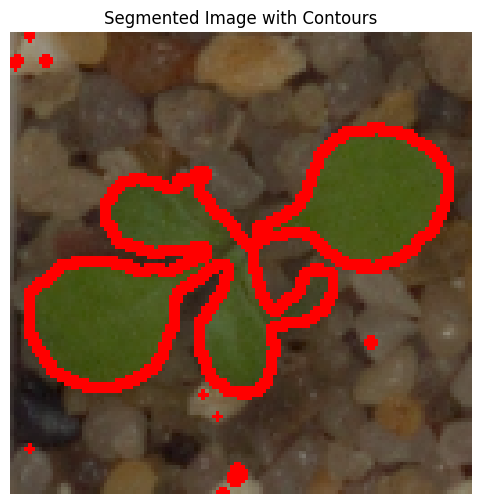

In [16]:
# Convert mask to binary for contour detection
contours, _ = cv2.findContours(green_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Draw contours on original image
contour_img = sample_img.copy()
cv2.drawContours(contour_img, contours, -1, (255, 0, 0), 2)  # Blue contours

# Show segmented image with contours
plt.figure(figsize=(6,6))
plt.imshow(contour_img)
plt.title("Segmented Image with Contours")
plt.axis('off')
plt.show()

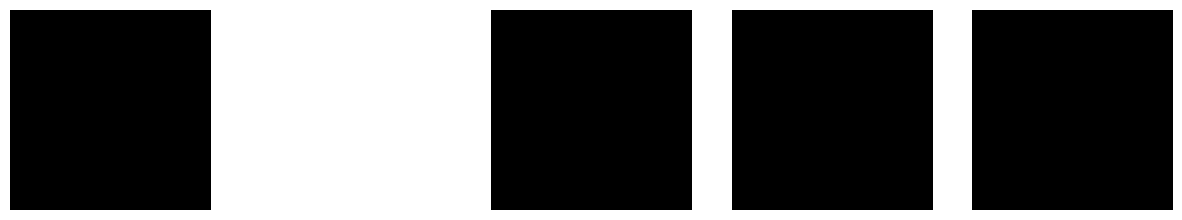

In [17]:
import tensorflow as tf

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomBrightness(0.1)
])

augmented_batch = data_augmentation(X_train[:5])

fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    axes[i].imshow(augmented_batch[i])
    axes[i].axis('off')

plt.show()

In [18]:
import numpy as np

# Identify crop & weed indices
crop_indices = np.where(y_train[:, :5].sum(axis=1) > 0)[0]  # First 5 classes are crops
weed_indices = np.where(y_train[:, :5].sum(axis=1) == 0)[0]  # The rest are weeds

# Compute oversampling factor
oversample_factor = len(weed_indices) // len(crop_indices)

# Oversample crops
oversampled_crops = np.tile(X_train[crop_indices], (oversample_factor, 1, 1, 1))
oversampled_labels = np.tile(y_train[crop_indices], (oversample_factor, 1))

# Merge back with original training set
X_train_balanced = np.concatenate((X_train, oversampled_crops), axis=0)
y_train_balanced = np.concatenate((y_train, oversampled_labels), axis=0)

print("Balanced Training set size:", X_train_balanced.shape)

Balanced Training set size: (6069, 128, 128, 3)


In [19]:
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.arange(len(mlb.classes_)), y=np.argmax(y_train, axis=1))
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

print("Class Weights:", class_weight_dict)

Class Weights: {0: 1.5646186440677967, 1: 1.0490056818181819, 2: 1.3675925925925927, 3: 0.645541958041958, 4: 1.7752403846153846, 5: 0.8667840375586855, 6: 0.581496062992126, 7: 1.7838164251207729, 8: 0.7474696356275303, 9: 1.733568075117371, 10: 0.8009761388286334, 11: 1.0343137254901962}


In [20]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D

# Define CNN model
model = Sequential([
    # First Conv Block
    Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(128, 128, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),

    # Second Conv Block
    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    
    # Third Conv Block
    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    
    # Fourth Conv Block
    Conv2D(256, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),

    # Global Average Pooling instead of Flatten
    GlobalAveragePooling2D(),

    # Fully Connected Layers
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),

    # Output layer with sigmoid for multi-label classification
    Dense(len(mlb.classes_), activation='sigmoid')
])

# Print model summary
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 16, 16, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 12)                  │             780 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 432,268 (1.65 MB)

 Trainable params: 431,308 (1.65 MB)

 Non-trainable params: 960 (3.75 KB)

In [21]:
# Compile the model
model.compile(
    loss='binary_crossentropy',  # Since it's multi-label classification
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

In [22]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Reduce learning rate when validation loss stops improving
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, verbose=1)

# Train again with this callback
history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=20, batch_size=32, callbacks=[lr_scheduler])


Epoch 1/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 158s 1s/step - accuracy: 0.1900 - loss: 0.4086 - val_accuracy: 0.1146 - val_loss: 0.3919 - learning_rate: 0.0010
Epoch 2/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 150s 1s/step - accuracy: 0.4295 - loss: 0.2259 - val_accuracy: 0.1146 - val_loss: 0.5425 - learning_rate: 0.0010
Epoch 3/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 218s 1s/step - accuracy: 0.5597 - loss: 0.1850 - val_accuracy: 0.1173 - val_loss: 0.5199 - learning_rate: 0.0010
Epoch 4/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 153s 1s/step - accuracy: 0.6343 - loss: 0.1591 - val_accuracy: 0.3312 - val_loss: 0.2892 - learning_rate: 0.0010
Epoch 5/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 150s 1s/step - accuracy: 0.6931 - loss: 0.1373 - val_accuracy: 0.4287 - val_loss: 0.2192 - learning_rate: 0.0010
Epoch 6/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 154s 1s/step - accuracy: 0.7336 - loss: 0.1163 - val_accuracy: 0.7130 - val_loss: 0.1136 - learning_rate: 0.0010
Epoch 7/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 166s 1s/step - accuracy: 0.7782 - loss: 0.

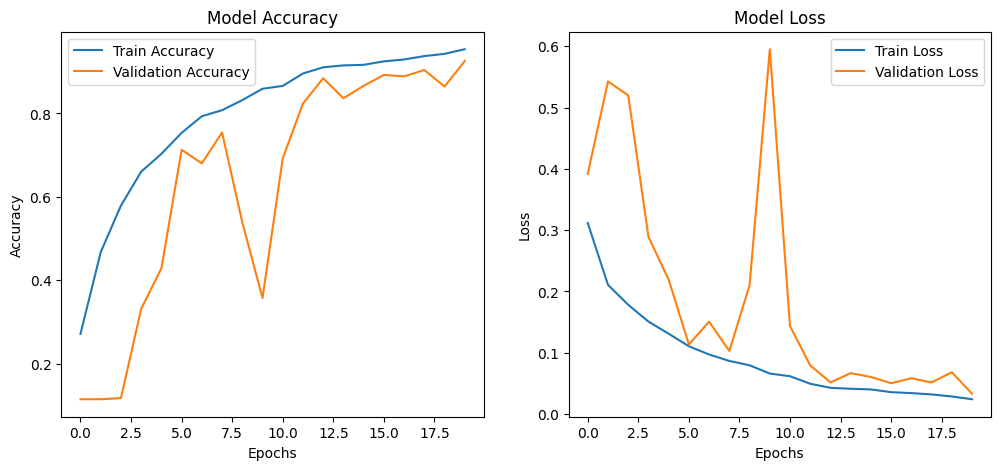

In [23]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')

# Plot loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')

plt.show()

In [24]:
# Evaluate model on validation set
test_loss, test_acc = model.evaluate(X_val, y_val)

print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 229ms/step - accuracy: 0.9220 - loss: 0.0340
Test Accuracy: 92.60%
Test Loss: 0.0331


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


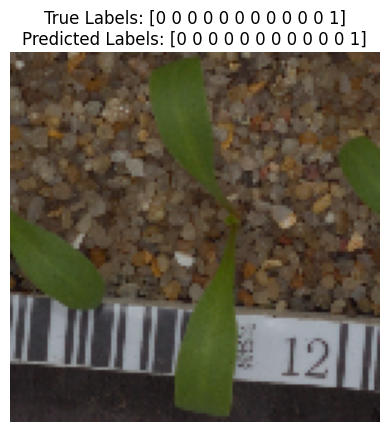

In [25]:
import numpy as np

# Pick a random image from the validation set
idx = np.random.randint(len(X_val))
test_img = X_val[idx]
test_label = y_val[idx]

# Model prediction
pred = model.predict(np.expand_dims(test_img, axis=0))[0]  # Expand dimension for batch format
pred_classes = (pred > 0.5).astype(int)  # Convert probabilities to binary (0 or 1)

# Display result
plt.imshow(test_img)
plt.axis('off')
plt.title(f"True Labels: {test_label}\nPredicted Labels: {pred_classes}")
plt.show()

35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 210ms/step


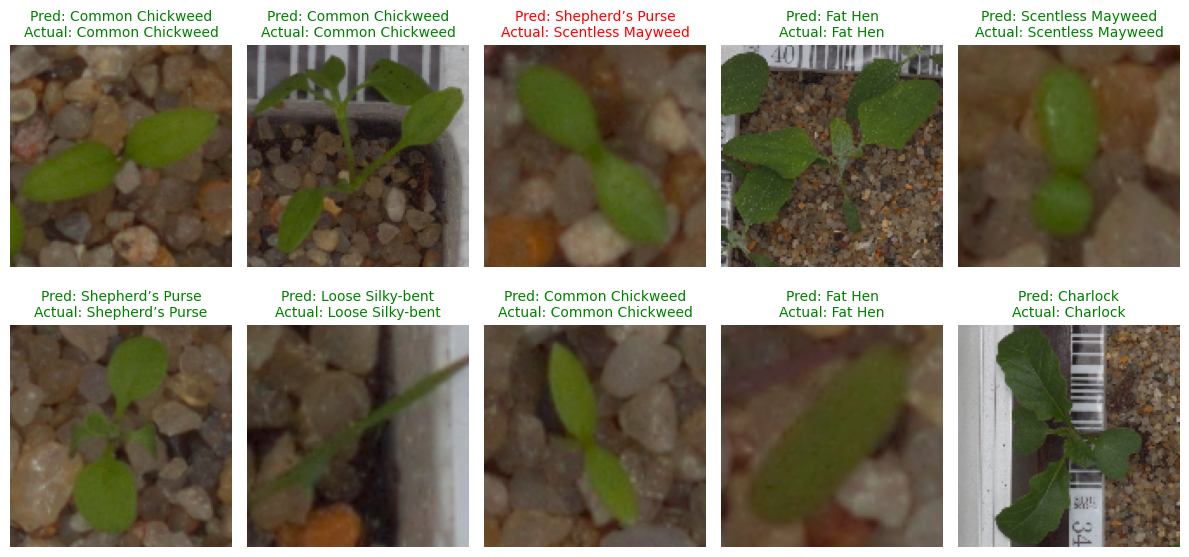

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Ensure we are predicting on X_val
pred_probs = model.predict(X_val)  # Predict class probabilities
pred_classes = np.argmax(pred_probs, axis=1)  # Get class indices

# Number of images to display
num_images = min(10, len(X_val))

# Select random indices safely within the dataset range
indices = np.random.choice(len(X_val), num_images, replace=False)

# Get the corresponding images, actual labels, and predicted labels
selected_images = X_val[indices]
selected_actual_labels = np.argmax(y_val[indices], axis=1)  # Convert one-hot to class index
selected_pred_labels = pred_classes[indices]  # Predicted class indices

# Convert class indices to class names
actual_class_names = [class_names[i] for i in selected_actual_labels]
pred_class_names = [class_names[i] for i in selected_pred_labels]

# Plot images with predictions
plt.figure(figsize=(12, 6))
for i in range(num_images):
    plt.subplot(2, 5, i+1)
    plt.imshow(selected_images[i])
    plt.axis('off')
    plt.title(f"Pred: {pred_class_names[i]}\nActual: {actual_class_names[i]}",
              fontsize=10, color="green" if pred_class_names[i] == actual_class_names[i] else "red")

plt.tight_layout()
plt.show()


In [27]:
from sklearn.metrics import classification_report

# Ensure class_names has the correct length
correct_class_names = class_names[:12]  # Keep only the first 12 if there's an extra one

# Generate classification report
report = classification_report(y_val.argmax(axis=1), pred_classes, target_names=correct_class_names)
print(report)

                           precision    recall  f1-score   support

              Black-grass       0.81      0.82      0.82        73
                 Charlock       0.90      0.99      0.94       100
                 Cleavers       0.97      0.94      0.95        65
         Common Chickweed       0.96      0.97      0.96       141
             Common wheat       0.91      0.96      0.93        45
                  Fat Hen       0.97      0.96      0.97       112
         Loose Silky-bent       0.89      0.88      0.89       127
                    Maize       0.92      0.98      0.95        50
        Scentless Mayweed       0.97      0.84      0.90       113
         Shepherd’s Purse       0.79      0.90      0.84        61
Small-flowered Cranesbill       0.95      0.97      0.96       115
               Sugar beet       1.00      0.90      0.95       106

                 accuracy                           0.93      1108
                macro avg       0.92      0.93      0.92    

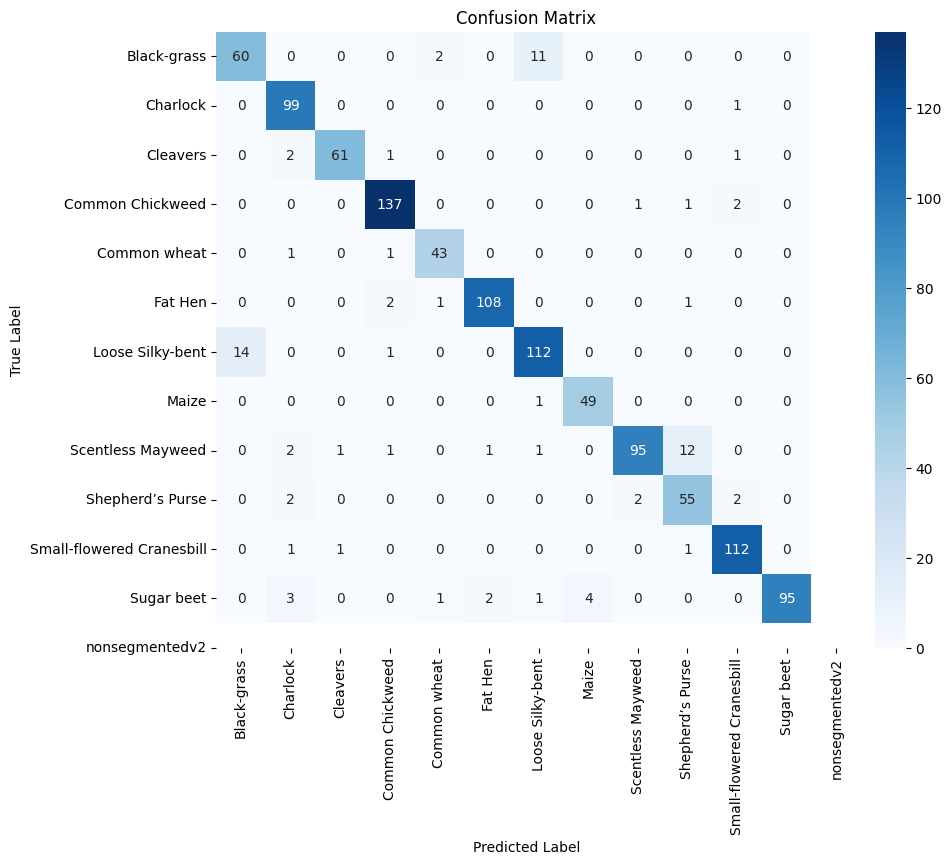

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_val.argmax(axis=1), pred_classes)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [29]:
from sklearn.metrics import roc_auc_score
import numpy as np

# Compute AUC score
auc_score = roc_auc_score(y_val, pred_probs, multi_class="ovr")
print(f"Overall AUC Score: {auc_score:.4f}")

Overall AUC Score: 0.9957


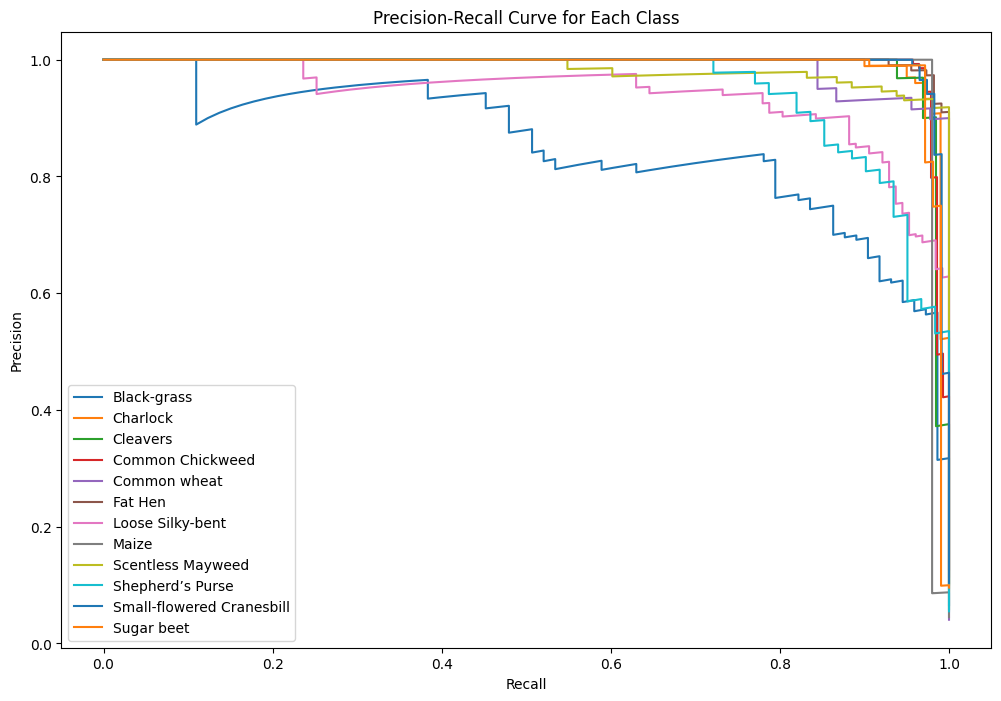

In [30]:
from sklearn.metrics import precision_recall_curve

plt.figure(figsize=(12, 8))

for i in range(len(class_names[:12])):
    precision, recall, _ = precision_recall_curve(y_val[:, i], pred_probs[:, i])
    plt.plot(recall, precision, label=class_names[i])

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for Each Class")
plt.legend()
plt.show()

In [32]:
from tensorflow.keras.models import load_model


# OR Save in HDF5 format (.h5) if needed
model.save('weed_classification_model.h5')
print("✅ Model successfully saved as 'weed_classification_model.h5'")


✅ Model successfully saved as 'weed_classification_model.h5'
